In [1]:
from sklearn.datasets import fetch_openml

wine_reviews = fetch_openml(data_id=42074, as_frame=True)

df = wine_reviews.frame
df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


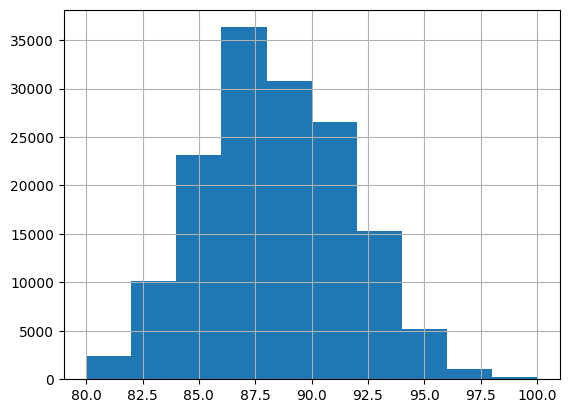

In [2]:
numerical_features = ["price"]
categorical_features = [
    "country",
    "province",
    "region_1",
    "region_2",
    "variety",
    "winery",
]
target_name = "points"

X = df[numerical_features + categorical_features]
y = df[target_name]

_ = y.hist()

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous")),
]

In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

n_cv_folds = 3
max_iter = 20
results = []


def evaluate_model_and_store(name, pipe):
    result = cross_validate(
        pipe,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=n_cv_folds,
        return_train_score=True,
    )
    rmse_test_score = -result["test_score"]
    rmse_train_score = -result["train_score"]
    results.append(
        {
            "preprocessor": name,
            "rmse_test_mean": rmse_test_score.mean(),
            "rmse_test_std": rmse_train_score.std(),
            "rmse_train_mean": rmse_train_score.mean(),
            "rmse_train_std": rmse_train_score.std(),
        }
    )


for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state=0, max_iter=max_iter)
    )
    evaluate_model_and_store(name, pipe)

In [5]:
n_unique_categories = df[categorical_features].nunique().sort_values(ascending=False)
n_unique_categories

winery      14810
region_1     1236
variety       632
province      455
country        48
region_2       18
dtype: int64

In [6]:
high_cardinality_features = n_unique_categories[n_unique_categories > 255].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 255].index
# 카테고리 특성과 수치 특성을 결합하여 전처리를 위한 ColumnTransformer를 설정합니다.
# 파이프라인을 구성하고 히스토그램 기울기 부스팅 회귀 모델을 평가하여 결과를 저장합니다.
preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),  # 수치 특성은 그대로 전달됩니다.
        ("categorical", categorical_preprocessor, categorical_features),  # 카테고리 특성에 전처리를 적용합니다.
    ]
)
pipe = make_pipeline(
    preprocessor, HistGradientBoostingRegressor(random_state=0, max_iter=max_iter)
)
evaluate_model_and_store(name, pipe)

# 높은 기준수를 가진 특성에는 TargetEncoder를, 낮은 기준수를 가진 특성에는 OrdinalEncoder를 적용하는 전처리 과정을 설정합니다.
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),  # 수치 특성은 그대로 전달됩니다.
        ("high_cardinality", TargetEncoder(target_type="continuous"), high_cardinality_features),  # 높은 기준수 특성에 TargetEncoder를 적용합니다.
        ("low_cardinality", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), low_cardinality_features),  # 낮은 기준수 특성에 OrdinalEncoder를 적용합니다.
    ],
    verbose_feature_names_out=False,
)
mixed_encoded_preprocessor.set_output(transform="pandas")  # 전처리 결과를 판다스로 설정합니다.

# 혼합된 인코딩 스키마를 적용한 파이프라인을 설정합니다.
mixed_pipe = make_pipeline(
    mixed_encoded_preprocessor,
    HistGradientBoostingRegressor(
        random_state=0, max_iter=max_iter, categorical_features=low_cardinality_features
    ),
)

# 혼합된 인코딩 스키마를 적용한 파이프라인을 평가하여 결과를 저장합니다.
evaluate_model_and_store("mixed_target", mixed_pipe)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['price']),
                                                 ('high_cardinality',
                                                  TargetEncoder(target_type='continuous'),
                                                  Index(['winery', 'region_1', 'variety', 'province'], dtype='object')),
                                                 ('low_cardinality',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['country', 'region_2'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['country', 'region_2'], dtype='object'),
                                               max_iter=20, random_state=0))])

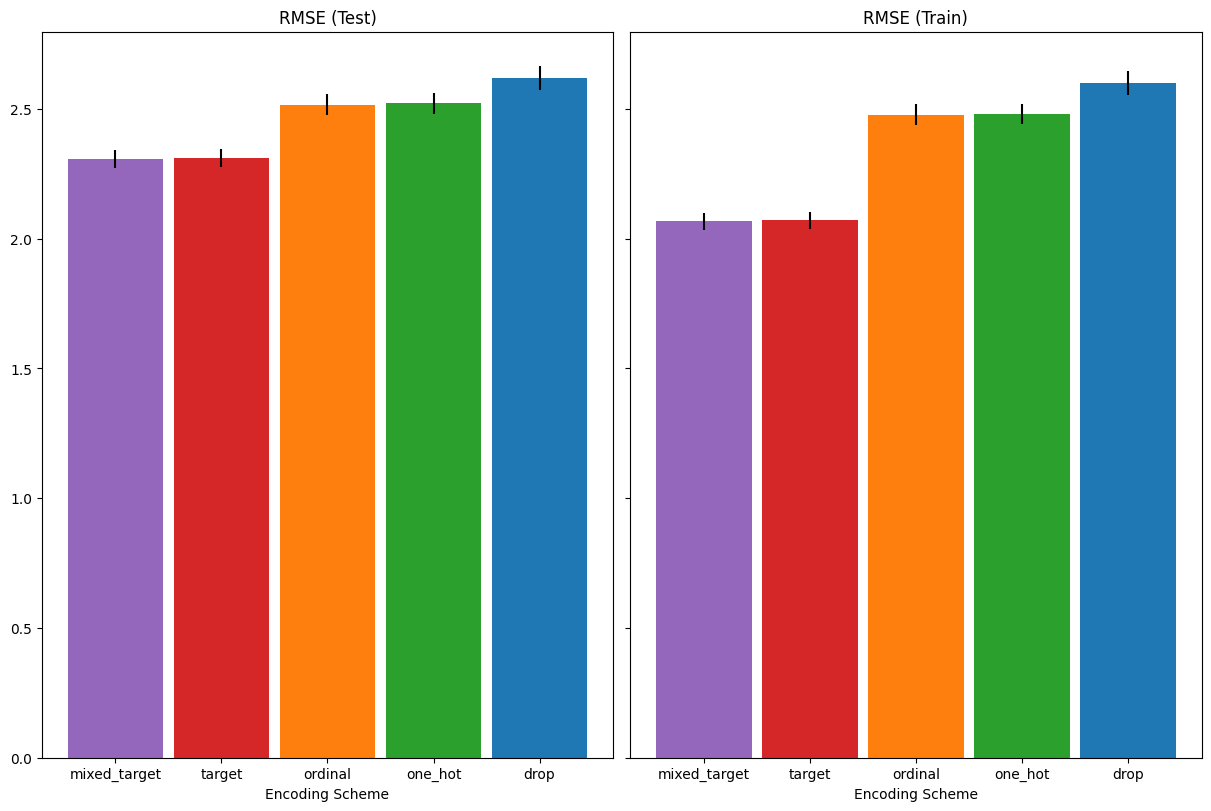

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = (
    pd.DataFrame(results).set_index("preprocessor").sort_values("rmse_test_mean")
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 8), sharey=True, constrained_layout=True
)
xticks = range(len(results_df))
name_to_color = dict(
    zip((r["preprocessor"] for r in results), ["C0", "C1", "C2", "C3", "C4"])
)

for subset, ax in zip(["test", "train"], [ax1, ax2]):
    mean, std = f"rmse_{subset}_mean", f"rmse_{subset}_std"
    data = results_df[[mean, std]].sort_values(mean)
    ax.bar(
        x=xticks,
        height=data[mean],
        yerr=data[std],
        width=0.9,
        color=[name_to_color[name] for name in data.index],
    )
    ax.set(
        title=f"RMSE ({subset.title()})",
        xlabel="Encoding Scheme",
        xticks=xticks,
        xticklabels=data.index,
    )